In [25]:
import torch
import torch.nn as nn
from bindsnet.datasets import MNIST
from bindsnet         import encoding
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
from bindsnet.network.topology import Connection
from bindsnet.network.nodes import LIFNodes, Input
import matplotlib.pyplot as plt

In [18]:
network = Network()
inpt = Input(10);network.add_layer(inpt,name='I')
output = LIFNodes(10); network.add_layer(output, name='O')
network.add_connection(Connection(inpt, output), 'I', 'O')
network.add_monitor(Monitor(output, ['s'], time=100), name='output_spikes')

In [20]:
data = 15 * torch.rand(100)
train = encoding.poisson(datum=data, time=1000)
train.shape

torch.Size([1000, 100])

In [31]:
'''
Setup
'''

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys
np.set_printoptions(threshold=sys.maxsize)
disp_figs = True
import colorsys

def create_color_spectrum(num_labels):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')

    return colors

# Existing colors represented as hexadecimal strings
existing_colors = np.array(['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Create a palette with 101 colors (11 existing + 90 new)
num_new_colors = 90
new_colors = create_color_spectrum(num_new_colors)
palette = np.concatenate([existing_colors, new_colors])

In [76]:
'''
Model parameters
'''
import random
import numpy as np

M = 10 # Number of Spiking motifs
N = 100 # Number of input neurons
D = 71 # temporal depth of receptive field
T = 4000
dt = 1
nrn_fr = 3 # hz
pg_fr = 3 # hz
background_noise_fr = 1 # h
np.random.seed(41)

In [77]:
'''
Synthetic Data Generation
'''
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)
K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)

# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)
B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,0] = np.random.randint(0,999,(N,T+D))
A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b-1]
    
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1

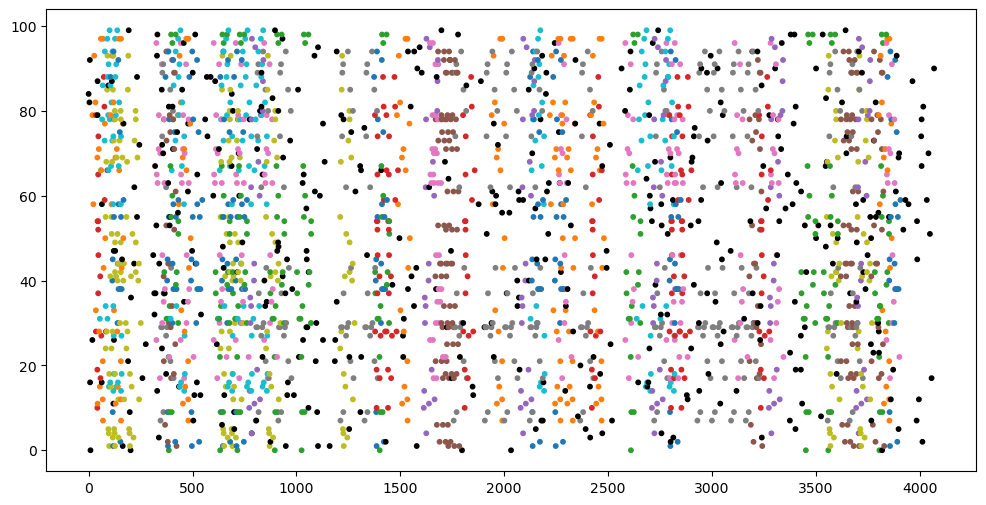

In [78]:
plt.figure(figsize=(12,6))
plt.scatter(A_sparse[1],A_sparse[0],c=palette[A_sparse[2]],s=10)
plt.show()

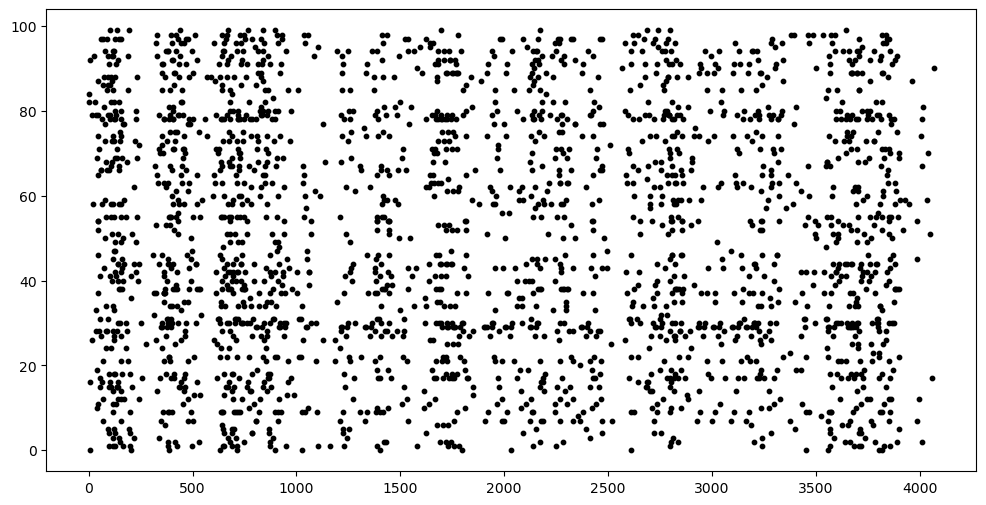

In [79]:
plt.figure(figsize=(12,6))
plt.scatter(A_sparse[1],A_sparse[0],c='black',s=10)
plt.show()